In [ ]:
# %pip install tqdm


In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler


Segmentation Models: using `keras` framework.


In [2]:
scaler = MinMaxScaler()

from smooth_tiled_predictions import predict_img_with_smooth_windowing



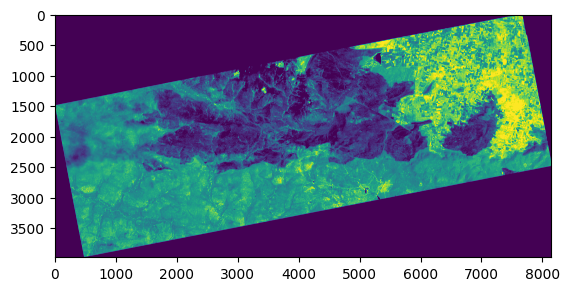

In [3]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

img = cv2.imread("data/images/812.tif")
plt.imshow(img[:,:,2])
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
image = preprocess_input(input_img)

original_mask = cv2.imread("data/masks/812_mask.tif")
original_mask = original_mask[:,:,0]  #Use only single channel...
#original_mask = to_categorical(original_mask, num_classes=n_classes)

In [4]:
# import numpy as np

# # Assuming input_img is a NumPy array
# input_img = input_img.astype(np.float32)

# # Now, input_img has been converted to float32 data type.
image.shape

(3979, 8139, 3)

In [6]:
from keras.models import load_model
model = load_model("Latest_500.hdf5", compile=False)

In [7]:
seed=24
batch_size= 8
n_classes=2
patch_size=256

In [8]:
# import tensorflow as tf

# # Your code here to build the model and load data

# # Get the CPU and GPU devices
# cpu_device = tf.device('/CPU:0')
# gpu_device = tf.device('/GPU:0')
# input_data_gpu = tf.identity(input_img)

# # # Use the devices to copy tensors between CPU and GPU
# # with cpu_device:
# #     input_data_cpu = tf.constant(input_img, dtype=tf.float32)
# # with gpu_device:
# #     input_data_gpu = tf.identity(input_img)


In [9]:
# # Define your custom prediction function
# def custom_predict(img_batch_subdiv, model):
#     # Perform any preprocessing on the image batch if needed
#     # For example, you can normalize the batch to values between 0 and 1
# #     preprocessed_batch = img_batch_subdiv / 255.0

#     # Make the prediction using the model
#     predictions = model.predict(img_batch_subdiv)

#     return predictions


In [10]:

# # Call predict_img_with_smooth_windowing with your custom prediction function
# predictions_smooth = predict_img_with_smooth_windowing(
#     image,
#     window_size=patch_size,
#     subdivisions=2,
#     nb_classes=n_classes,
#     pred_func=lambda img_batch_subdiv:custom_predict(img_batch_subdiv, model)  # Use your custom prediction function
# )


In [11]:
import numpy as np

# Define the function to predict a single patch
def predict_patch(input_patch, model):
    # Pad or crop the input_patch to size (256, 256, 3)
    target_shape = (256, 256, 3)
    input_shape = input_patch.shape
    pad_height = max(target_shape[0] - input_shape[0], 0)
    pad_width = max(target_shape[1] - input_shape[1], 0)
    input_patch = np.pad(input_patch, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0.0)
    input_patch = input_patch[:target_shape[0], :target_shape[1], :]

    # Add a batch dimension to the input_patch
    print(input_patch.shape)
    input_patch = np.expand_dims(input_patch, axis=0)
    # Convert the input_patch to dtype float32
    input_patch = input_patch.astype(np.float32)
    print(input_patch.dtype)
    #predict on the patch
    prediction = model.predict(input_patch)
    return prediction

# def predict_patch(input_patch, model):
#     # Pad or crop the input_patch to size (256, 256, 3)
#     target_shape = (256, 256, 3)
#     input_shape = input_patch.shape
#     pad_height = max(target_shape[0] - input_shape[0], 0)
#     pad_width = max(target_shape[1] - input_shape[1], 0)

#     # Create a new array filled with white pixels (255)
#     padded_patch = np.ones(target_shape, dtype=np.uint8) * 255

#     # Calculate the regions to be covered by the original input_patch
#     patch_end_height = min(target_shape[0], input_shape[0])
#     patch_end_width = min(target_shape[1], input_shape[1])

#     # Fill the corresponding region with the values from the input_patch
#     padded_patch[:patch_end_height, :patch_end_width, :] = input_patch[:patch_end_height, :patch_end_width, :]

#     # Add a batch dimension to the padded_patch
#     padded_patch = np.expand_dims(padded_patch, axis=0)
#     # Convert the padded_patch to dtype float32
#     padded_patch = padded_patch.astype(np.float32)

#     # Predict on the padded_patch
#     prediction = model.predict(padded_patch)
#     return prediction


# Define the function to make predictions for the entire image using smooth windowing
def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, model):
    img_height, img_width, _ = input_img.shape

    # Initialize the prediction result
    predictions_smooth = np.zeros((img_height, img_width, nb_classes), dtype=np.float64)

    # Iterate over each patch using the given window_size
    for x in range(0, img_width, window_size // subdivisions):
        for y in range(0, img_height, window_size // subdivisions):
            x_end = min(x + window_size, img_width)
            y_end = min(y + window_size, img_height)

            # Extract the current patch from the input image
            input_patch = input_img[y:y_end, x:x_end]

            # Predict the patch using the model
            prediction_patch = predict_patch(input_patch, model)

            # Update the corresponding region in the predictions_smooth array
            predictions_smooth[y:y_end, x:x_end] = prediction_patch[0, :y_end - y, :x_end - x]

    return predictions_smooth


In [12]:
input_img =input_img
window_size = 256
subdivisions = 2
nb_classes =2
your_model =model

In [13]:
predictions_smooth = predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, your_model)


(256, 256, 3)
float32
1/1 [==============================] - 7s 7s/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 23ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 19ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 16ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 42ms/step
(256, 256, 3)
float32
1/1 [=============

1/1 [==============================] - 0s 17ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 50ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 48ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 37ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 37ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 37ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 39ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 38ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 37ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 38ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 42ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 38ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 37ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 39ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 39ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 39ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 39ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 37ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 38ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 38ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 41ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 38ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 40ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 38ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 37ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 25ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 38ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 36ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 38ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 35ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 32ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 33ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 34ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [=========================

1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] -

1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 26ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] -

float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 29ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 28ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 31ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 30ms/step
(256, 256, 3)
float32
1/1 [==============================] - 0s 27ms/step
(256, 256, 3)
float32
1/1 [=========================

In [14]:
final_prediction = np.argmax(predictions_smooth, axis=2)
final_prediction.shape

(3979, 8139)

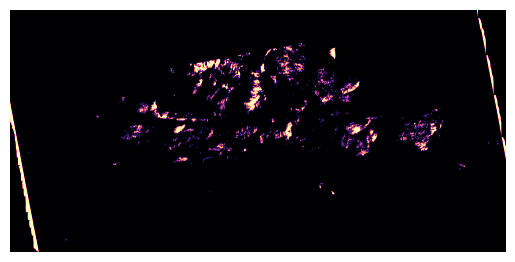

In [15]:
plt.imshow(final_prediction, cmap='magma')
plt.axis('off')
plt.savefig('data/res/812_Seg.jpg', bbox_inches='tight', pad_inches=0) 


In [26]:
if img.mode != 'RGB':
    img = img.convert('RGB')

# Save the image without the axis in RGB format
img.save('data/res/812.jpg', format='JPEG', quality=95)

In [17]:
# from PIL import Image
# import numpy as np

# # ... your existing code ...
# img_array = np.array(final_prediction)
# # Apply the mask to keep only non-background pixels
# img_array_masked = img_array * mask

# # Convert the data type to uint8 if necessary
# if img_array_masked.dtype != np.uint8:
#     # Scale the masked array to the range 0-255 if it's not already in this range.
#     # You might need to adjust this depending on how your data is scaled.
#     img_array_masked = (img_array_masked / img_array_masked.max()) * 255
#     img_array_masked = img_array_masked.astype(np.uint8)

# # Now img_array_masked contains only the image without the background
# result_image = Image.fromarray(img_array_masked)
# result_image.save('data/res/813_crop.tif')


NameError: name 'mask' is not defined

In [20]:
plt.imsave('data/res/812_Seg.jpg', final_prediction)
plt.imsave('data/res/812_mask.jpg', original_mask)

In [ ]:
%pip install imageio


In [18]:
import matplotlib.pyplot as plt
import imageio

# Assuming 'final_prediction' and 'original_mask' are your image arrays

# Save final_prediction as TIFF
imageio.imsave('data/res/812_Seg.tif', final_prediction)

# Save original_image as TIFF
imageio.imsave('data/res/812.tif', img)
